# Mortgage Credit Risk Analytics: Data Wrangling & Exploration

The broader macroeconomic story is evident from exploring the plots of the macro variables included in the dataset: GDP, unemployment, and the national housing price index. The data is consistent with the well known story of the financial crisis in the late 2000's. Central to the crisis (and without diving into the causes and broader consequences), housing prices experienced a collapse that was unprecedented in the United States in modern times.

The consequence of this was that large numbers of mortgages that were otherwise considered to have acceptable risk profiles went underwater as the value of the asset became worth less than the remaining balance of the mortgage. This is evident in the distribution of the loan-to-value ratio over time and the corresponding drop in the national housing price index. At this same point in time, the rates of loan repayment fall sharply and default rates skyrocketed.

This initial exploration looked at the broad trends in our dataset and the feedback loop between the housing market and the broader macroeconomic environment. However, it did not investigate if there are individual-level predictors that could have been used to identify loans at higher risk of default. The factors looked at in isolation in this analysis do not appear to be obvious predictors of default and it will need to be further investigated whether there are certain specifications or combinations of factors in the dataset that can be used to predict mortgage defaults.

Link to dataset: http://www.creditriskanalytics.net/datasets-private.html
Data is available by selecting "Mortgage (Compressed)" in the "For R and Other Packages" section

In [1]:
# Import dependencies
import numpy as np
import joypy
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns
from scipy import stats
import lifelines

In [2]:
# Import credit risk dataset
df = pd.read_csv(r"C:\Users\andre\OneDrive\Springboard\Large_Data\mortgage.csv")

In [3]:
# Inspect data types and counts in dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 622489 entries, 0 to 622488
Data columns (total 23 columns):
id                         622489 non-null int64
time                       622489 non-null int64
orig_time                  622489 non-null int64
first_time                 622489 non-null int64
mat_time                   622489 non-null int64
balance_time               622489 non-null float64
LTV_time                   622219 non-null float64
interest_rate_time         622489 non-null float64
hpi_time                   622489 non-null float64
gdp_time                   622489 non-null float64
uer_time                   622489 non-null float64
REtype_CO_orig_time        622489 non-null int64
REtype_PU_orig_time        622489 non-null int64
REtype_SF_orig_time        622489 non-null int64
investor_orig_time         622489 non-null int64
balance_orig_time          622489 non-null float64
FICO_orig_time             622489 non-null int64
LTV_orig_time              622489 non-null

In [4]:
df.head()

,id,time,orig_time,first_time,mat_time,balance_time,LTV_time,interest_rate_time,hpi_time,gdp_time,...,REtype_SF_orig_time,investor_orig_time,balance_orig_time,FICO_orig_time,LTV_orig_time,Interest_Rate_orig_time,hpi_orig_time,default_time,payoff_time,status_time
0,1,25,-7,25,113,41303.42,24.498336,9.2,226.29,2.899137,...,1,0,45000.0,715,69.4,9.2,87.03,0,0,0
1,1,26,-7,25,113,41061.95,24.483867,9.2,225.10,2.151365,...,1,0,45000.0,715,69.4,9.2,87.03,0,0,0
2,1,27,-7,25,113,40804.42,24.626795,9.2,222.39,2.361722,...,1,0,45000.0,715,69.4,9.2,87.03,0,0,0
3,1,28,-7,25,113,40483.89,24.735883,9.2,219.67,1.229172,...,1,0,45000.0,715,69.4,9.2,87.03,0,0,0
4,1,29,-7,25,113,40367.06,24.925476,9.2,217.37,1.692969,...,1,0,45000.0,715,69.4,9.2,87.03,0,0,0


### Data Exploration & Verification

Before doing any analysis, the size and characteristics of the data have to be explored. In particular, the number of censored and uncensored observations need to be counted as a percentage of the available dataset.

#### Number of Unique Mortgages

Count the number of unique mortgages in the dataset:

In [5]:
mortgage_count = len(df.groupby('id').count().reset_index().index)
f'There are {mortgage_count} unique mortgages in the dataset'

'There are 50000 unique mortgages in the dataset'

#### Censored Observations

How many mortgages in the dataset are censored?

In [6]:
# sum the 'default time' and 'payoff time' to get total number of defaults and paid off mortgages over the 15 years of data
censored_counts = df[['default_time','payoff_time']].sum()
print(censored_counts)

default_time    15158
payoff_time     26589
dtype: int64


In [7]:
f'Out of the total {mortgage_count} unique mortgages, {censored_counts[0]} defaulted and {censored_counts[1]} were paid off within the time frame of the dataset'

'Out of the total 50000 unique mortgages, 15158 defaulted and 26589 were paid off within the time frame of the dataset'

In [8]:
f'The remaining {mortgage_count - censored_counts.sum()} mortgages are right-censored because we do not observe default or payoff.'

'The remaining 8253 mortgages are right-censored because we do not observe default or payoff.'

In [9]:
f'For techniques that cannot use censored observations {(mortgage_count - censored_counts.sum())/mortgage_count*100}% of the mortgages need to be thrown out.'

'For techniques that cannot use censored observations 16.506% of the mortgages need to be thrown out.'

##### Macro Variables

In [10]:
# Create series of quarters starting with Q3 1999, the first quarter in the dataset
quarters = pd.Series(pd.date_range(start='1999-07-01', periods=60, freq='3M').to_period("Q"))
df_time_list = pd.Series(range(1,61))
date_index = pd.concat([df_time_list, quarters], axis=1)
date_index.columns = ['Time', 'Quarter']

# Create dataframe of macro variables
macros = df.groupby('time')[['hpi_time','gdp_time','uer_time']].mean().reset_index()
macros = macros.merge(date_index, left_on = 'time', right_on = 'Time', how = 'left')
macros = macros.set_index('Quarter')
macros.index = pd.date_range(start='1999-07-01', periods=60, freq='3M')

In [11]:
macros.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 1999-07-31 to 2014-04-30
Freq: 3M
Data columns (total 5 columns):
time        60 non-null int64
hpi_time    60 non-null float64
gdp_time    60 non-null float64
uer_time    60 non-null float64
Time        60 non-null int64
dtypes: float64(3), int64(2)
memory usage: 2.8 KB


How did the national house price index evolve over time?

Text(0, 0.5, 'House Price Index')

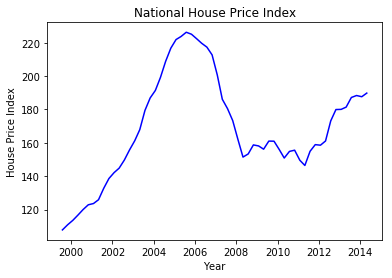

In [13]:
%matplotlib inline

# Plot the house price index time series in blue
plt.plot(macros['hpi_time'], color='blue', label='National House Price Index')
plt.title('National House Price Index')
plt.xlabel('Year')
plt.ylabel('House Price Index')

The housing boom which lasted through 2006 shows the national housing index more than doubling from the start of the dataset through 2005, before plummeting prior to and during the financial crisis.

How did GDP growth and unemployment change over time, particularly in relation to housing prices?

Text(0.5, 0, 'Year')

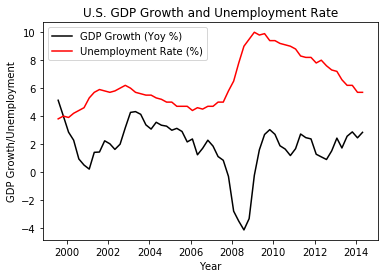

In [14]:
%matplotlib inline

# Plot the house price index time series in blue
plt.plot(macros['gdp_time'], color='black', label='GDP Growth (Yoy %)')
plt.plot(macros['uer_time'], color='red', label='Unemployment Rate (%)')

plt.title('U.S. GDP Growth and Unemployment Rate')
plt.legend(loc='upper left')
plt.ylabel('GDP Growth/Unemployment')
plt.xlabel('Year')

GDP growth went negative at the end of 2007, a lag of about a year from when houses prices started their decline. The unemployment rate increase followed the downturn in GDP and slowly normalized as growth returned to the normal quarterly rate of 1-3%.

### Impact of Macro Variables on Loan Characteristics

How did mortgage loan-to-value ratios (one metric used to estimate the riskiness of the loan) change as macroeconomic conditions worsened?

In [15]:
# Create dataframe of average loan-to-value ratio for each quarter and compare to national housing price index
ltv_hpi = df.groupby('time')[['LTV_time', 'hpi_time']].mean().reset_index()
ltv_hpi.index = pd.date_range(start='1999-07-01', periods=60, freq='3M')

Text(0.5, 0, 'Year')

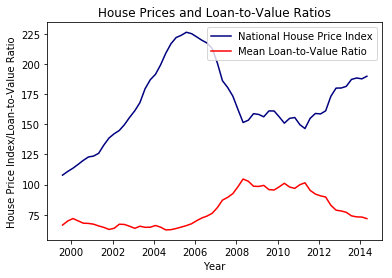

In [16]:
# Plot the mean loan-to-value ratio with national housing price index
plt.plot(ltv_hpi['hpi_time'], color='navy', label='National House Price Index')
plt.plot(ltv_hpi['LTV_time'], color='red', label='Mean Loan-to-Value Ratio')

plt.title('House Prices and Loan-to-Value Ratios')
plt.legend(loc='upper right')
plt.ylabel('House Price Index/Loan-to-Value Ratio')
plt.xlabel('Year')

The plot above shows that mean loan-to-value ratios were stable during the run up housing prices, but as soon as prices turned downward loan-to-value ratios increased substantially and did not return lower until housing prices began to recover in 2012.

In [17]:
# Create variables for percent of balance paid off and percent of time on loan elapsed
df['elapsed_perc'] = (df.time - df.orig_time)/(df.mat_time - df.orig_time)

df['perc_bal_paid'] = (df.balance_orig_time - df.balance_time)/df.balance_orig_time


In [18]:
df = df.merge(date_index, left_on = 'time', right_on = 'Time', how = 'left')

In [19]:
# Create dataframe of total mortgages and number of defaults and payoffs in each quarter
defaults = df.groupby('time')[['id','default_time','payoff_time']].agg({'id':'count',
                                                                       'default_time':'sum',
                                                                       'payoff_time':'sum'}).reset_index()
defaults.columns = ['time','mortgages', 'defaults', 'payoffs']

In [20]:
# Set index to quarters
defaults.index = pd.date_range(start='1999-07-01', periods=60, freq='3M')

How many mortgages are in the dataset for each quarter?

Text(0.5, 0, 'Year')

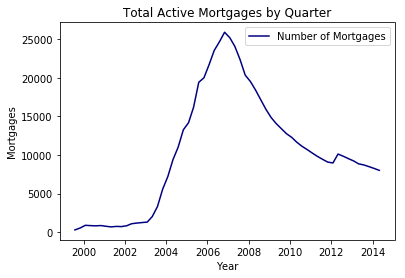

In [21]:
%matplotlib inline

# Plot the share of defaults and payoffs
plt.plot(defaults['mortgages'], color='navy', label = 'Number of Mortgages')

plt.title('Total Active Mortgages by Quarter')
plt.legend(loc='upper right')
plt.ylabel('Mortgages')
plt.xlabel('Year')

Do the proportion of mortgages being paid off or defaulted on change over time? Do changes in these rates correspond to changes in macro variables like house price index, GDP growth, and unemployment?

In [22]:
# Create share of mortgages in each period defaulting and being paid off
defaults['def_percent'] = defaults['defaults']/defaults['mortgages']
defaults['payoff_percent'] = defaults['payoffs']/defaults['mortgages']

The time series chart below shows the rates of mortgages paid off fall sharply and default rates increase substantially as housing prices were falling

Text(0.5, 0, 'Year')

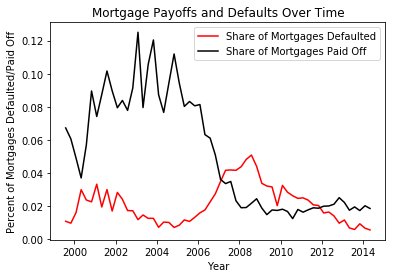

In [23]:
%matplotlib inline

# Plot the share of defaults and payoffs
plt.plot(defaults['def_percent'], color='red', label='Share of Mortgages Defaulted')
plt.plot(defaults['payoff_percent'], color='black', label='Share of Mortgages Paid Off')

plt.title('Mortgage Payoffs and Defaults Over Time')
plt.legend(loc='upper right')
plt.ylabel('Percent of Mortgages Defaulted/Paid Off')
plt.xlabel('Year')

### Loan-to-Value Ratio Distribution Over Time

Is the distribution of loan-to-value stable over time?

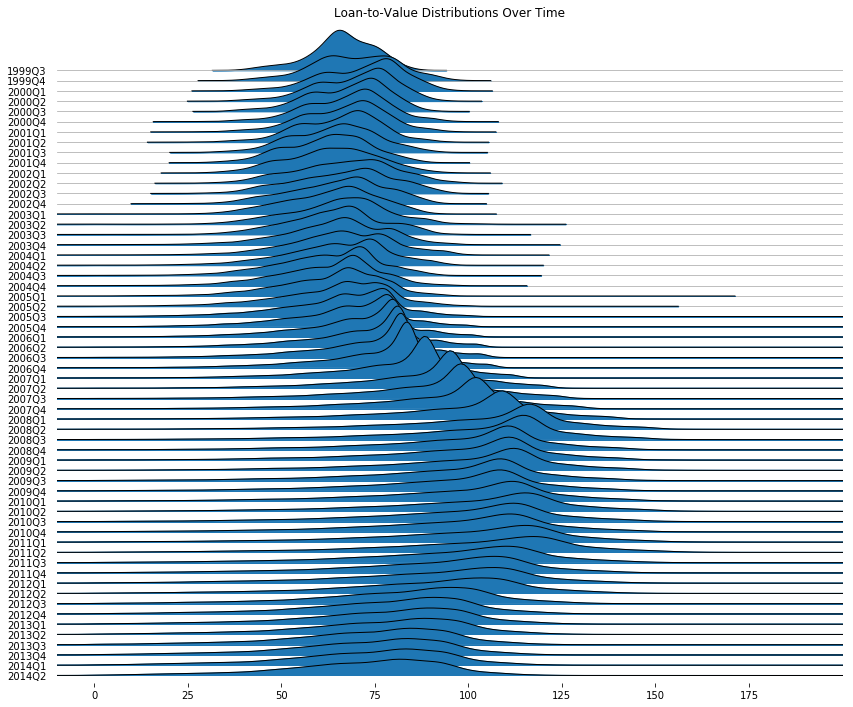

In [23]:
%matplotlib inline

fig, axes = joypy.joyplot(df, by="Quarter", column="LTV_time", range_style='own',
                          grid="y", linewidth=1, legend=False, fade=False, figsize=(12,10),
                          title="Loan-to-Value Distributions Over Time",
                          kind="kde", bins=20,
                          x_range=[-10,200])

# Statistical Tests

### Default/Payoff Rates by Type of Building

In [24]:
# Create a single variable corresponding to building type (1 = condo, 2 = urban development, 3 = single family home)
df['type'] = df['REtype_CO_orig_time'] + 2*df['REtype_PU_orig_time'] + 3*df['REtype_SF_orig_time']

In [25]:
# Transform numeric mapping into name of building type
type_lookup = {1:"Condo",
              2:"Urban Development",
              3:"Single Family"}

df['mortgage_type'] = df['type'].map(type_lookup)


Are there differences in the rates of payoffs and defaults between the three types of building (condo, single family, urban development)?

In [26]:
# Create dataframe to calculate total number of mortgages, defaults, and payoffs by building type
def_by_type = df.groupby(['id','mortgage_type'])[['default_time','payoff_time']].agg({'default_time':'sum',
                                        'payoff_time':'sum'}).reset_index()

def_by_type = def_by_type.groupby('mortgage_type')['id','default_time','payoff_time'].agg({'id':'count',
                                                                                           'default_time':'sum',
                                                                                           'payoff_time':'sum'}).reset_index()

def_by_type.columns = ['Mortgage Type', 'Count', 'Defaults', 'Paid Off']

In [27]:
# Create columns to calculate the share of mortgages by type of building that were paid off or defaulted on
def_by_type['Default Percent'] = def_by_type['Defaults']/def_by_type['Count']*100
def_by_type['Paid Off Percent'] = def_by_type['Paid Off']/def_by_type['Count']*100

In [28]:
# Display table
def_by_type

,Mortgage Type,Count,Defaults,Paid Off,Default Percent,Paid Off Percent
0,Condo,3250,1023,1718,31.476923,52.861538
1,Single Family,31192,9444,16662,30.276994,53.417543
2,Urban Development,5795,1853,3029,31.975841,52.269198


As the table and bar chart show the differences in default/payoff rate between building types are very small

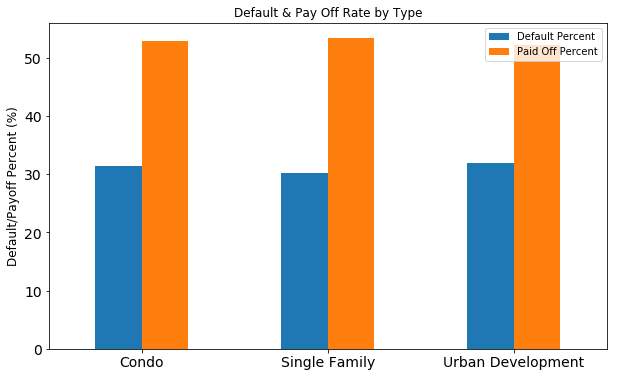

In [29]:
# Create bar chart to display the differences
def_by_type.index = def_by_type['Mortgage Type']

ax = def_by_type[['Default Percent','Paid Off Percent']].plot(kind='bar',
                                                     figsize=(10, 6),
                                                     legend=True,
                                                     fontsize=14, 
                                                     rot=0,
                                                     title ="Default & Pay Off Rate by Type")
ax.set_xlabel("", fontsize=12)
ax.set_ylabel("Default/Payoff Percent (%)", fontsize=12)
plt.show()

However, we will remove the right censored observations and do a formal significance test to determine whether there is a statistically significant difference in rates of default between types of building. Our test will 

- Null hypothesis: There is no difference in rates of default between condos, single family homes, and urban developments
- Alternative hypothesis: There is a difference in rates of default

### Investor vs Non-Investor Defaults

Is there any difference in rates of default and payoffs between investors and non-investors?

In [30]:
# Create dataframe of counts of mortgages by type (investor vs non-investor)
# Sums the number of mortgages, total defaults, and total payoffs
investor = df.groupby(['id','investor_orig_time'])[['default_time','payoff_time','orig_time']].agg({'default_time':'sum',
                                                                                                    'payoff_time':'sum',
                                                                                                   'orig_time':'max'}
                                                                                                  ).reset_index()

investor_summary = investor.groupby('investor_orig_time')[['id', 'default_time','payoff_time']].agg({'id':'count',
                                                                                             'default_time':'sum',
                                                                                             'payoff_time':'sum'}).reset_index()
# Relabel columns
investor_summary.columns = ['Investor', 'Count', 'Defaults', 'Payoffs']

In [31]:
# Create new columns to calculate the percentage of mortgages by type that were paid off or defaulted on
investor_summary['Default Percent'] = investor_summary['Defaults']/investor_summary['Count']*100
investor_summary['Payoff Percent'] = investor_summary['Payoffs']/investor_summary['Count']*100

In [32]:
# Display table
investor_summary

,Investor,Count,Defaults,Payoffs,Default Percent,Payoff Percent
0,0,44092,13196,23753,29.928332,53.871451
1,1,5922,1962,2836,33.130699,47.889227


The table and bar charts show that investors had a lower share of mortgages go into default and a higher share paid off than non-investors.

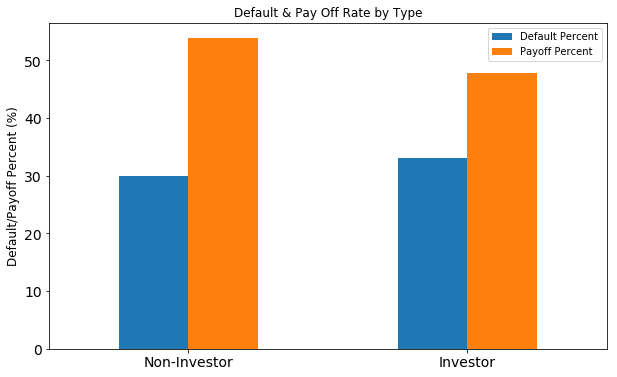

In [33]:
# Create barplot comparing default and payoff percentages by investor vs non-investor
investor_summary.index = ['Non-Investor', 'Investor']

ax = investor_summary[['Default Percent','Payoff Percent']].plot(kind='bar',
                                                     figsize=(10, 6),
                                                     legend=True,
                                                     fontsize=14, 
                                                     rot=0,
                                                     title ="Default & Pay Off Rate by Type")
ax.set_xlabel("", fontsize=12)
ax.set_ylabel("Default/Payoff Percent (%)", fontsize=12)
plt.show()

# Default vs Repaid Distibution of Loan-to-Value and FICO Score

Drop values that are right censored to compare distribution between mortgages that go into default vs those repaid

In [37]:
# Filter based on rows that only have non-zero value for 'status_time' which means they were either defaulted on or fully paid
df_reg = df.loc[df.status_time > 0 , ]

The distribution of loan-to-value of mortgages look similar for default vs repaid. The repaid appear to have a fatter tail to the left, but a more rigorous comparison would need to be made. Either way the distributions are more similar than you might expect and it does not seem that loan-to-value on its own would be a good predictor of default, although that doesn't mean it wouldn't be when used in combination with other predictors.

In [38]:
# Filter for loans originated in 25th quarter
df_reg = df_reg.loc[df_reg['orig_time'] == 25, ]

In [39]:
# Significance test to see whether FICO scores at 
df_FICO = df_reg.groupby('id')[['FICO_orig_time', 'status_time']].agg({'FICO_orig_time':'max',
                                                                   'status_time':'sum'}).reset_index()

In [40]:
df_FICO = df_FICO.loc[df_FICO.status_time > 0, ]

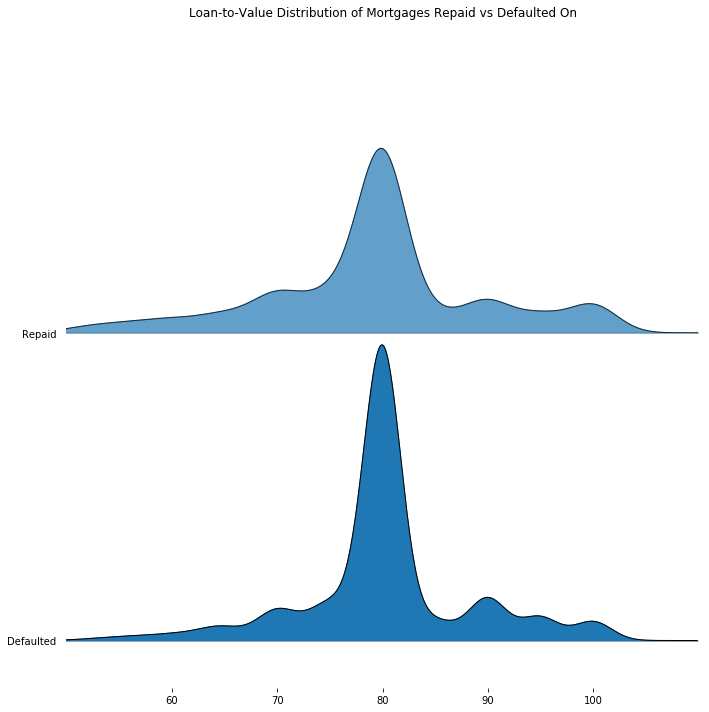

In [41]:
# Create plot to see difference in distribution of loan-to-value for mortgages that defaulted and those that were repaid
%matplotlib inline

fig, axes = joypy.joyplot(df_reg, by="default_time", column="LTV_orig_time", range_style='own',
                          grid="y", linewidth=1, legend=False, fade=True, figsize=(10,10),
                          labels = ['Repaid', 'Defaulted'],
                          title="Loan-to-Value Distribution of Mortgages Repaid vs Defaulted On",
                          kind="kde", bins=20,
                          x_range=[50,110])

The difference in FICO score distributions is more evident than it was for loan-to-value ratios. In particular, the repaid distribution has significantly more of its distribution in the 700+ FICO score range.

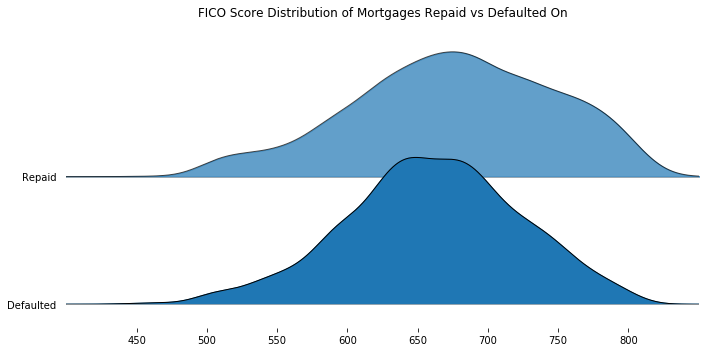

In [42]:
# Create plot to see difference in distribution of FICO Scores for mortgages that defaulted and those that were repaid
%matplotlib inline

fig, axes = joypy.joyplot(df_reg, by="default_time", column="FICO_orig_time", range_style='own',
                          grid="y", linewidth=1, legend=False, fade=True, figsize=(10,5),
                          labels = ['Repaid', 'Defaulted'],
                          title="FICO Score Distribution of Mortgages Repaid vs Defaulted On",
                          kind="kde", bins=20,
                          x_range=[400, 850])

In [43]:
df_reg.head()

,id,time,orig_time,first_time,mat_time,balance_time,LTV_time,interest_rate_time,hpi_time,gdp_time,...,hpi_orig_time,default_time,payoff_time,status_time,elapsed_perc,perc_bal_paid,Time,Quarter,type,mortgage_type
543,62,36,25,33,140,68552.85,132.997922,10.400,151.48,-3.516568,...,226.29,0,1,2,0.095652,0.010781,36,2008Q2,3,Single Family
549,63,38,25,33,140,152664.59,108.879775,7.205,158.77,-3.339549,...,226.29,0,1,2,0.113043,0.045095,38,2008Q4,3,Single Family
550,64,33,25,33,140,0.00,0.000000,11.000,180.52,0.836859,...,226.29,0,1,2,0.069565,1.000000,33,2007Q3,3,Single Family
605,67,33,25,33,141,61112.70,86.562191,11.750,180.52,0.836859,...,226.29,1,0,1,0.068966,0.013516,33,2007Q3,3,Single Family
611,68,38,25,33,141,82983.56,112.641826,9.840,158.77,-3.339549,...,226.29,0,1,2,0.112069,0.012100,38,2008Q4,3,Single Family


Text(0.5, 0, 'FICO Score')

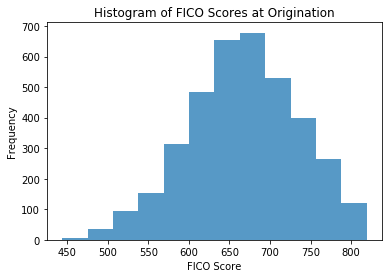

In [45]:
# Histogram of FICO scores at origination for uncensored loans

ax = df_reg['FICO_orig_time'].plot.hist(bins=12, alpha=0.75)
plt.title('Histogram of FICO Scores at Origination')
plt.xlabel('FICO Score')

In [46]:
df_pairplot = df.loc[:, ['balance_time',
                       'LTV_time',
                       'interest_rate_time',
                       'FICO_orig_time',
                       'default_time']]

C:\Users\andre\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\andre\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\andre\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\andre\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


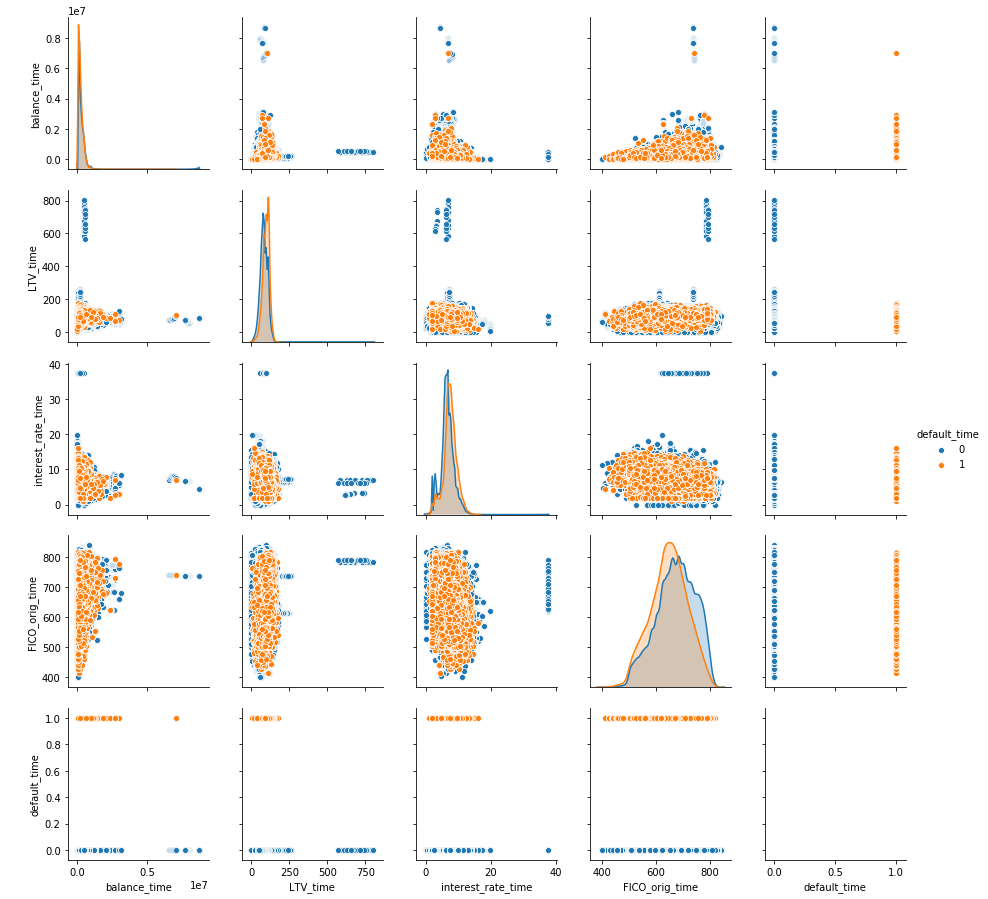

In [47]:
sns.pairplot(df_pairplot, hue = 'default_time')

#### Test for difference between building types

In [48]:
def_by_type = df.loc[df['orig_time'] == 25, ]


In [49]:
# Create dataframe to calculate total number of mortgages, defaults, and payoffs by building type
def_by_type = def_by_type.groupby(['id','mortgage_type'])[['default_time','payoff_time']].agg({'default_time':'sum',
                                        'payoff_time':'sum'}).reset_index()

def_by_type['Censored'] = def_by_type['default_time'] + def_by_type['payoff_time']

In [50]:
def_by_type.head()

,id,mortgage_type,default_time,payoff_time,Censored
0,62,Single Family,0,1,1
1,63,Single Family,0,1,1
2,64,Single Family,0,1,1
3,66,Single Family,0,0,0
4,67,Single Family,1,0,1


In [51]:
def_by_type = def_by_type.loc[def_by_type['Censored'] > 0, ]

def_by_type = def_by_type.groupby('mortgage_type')['default_time','payoff_time'].agg({'default_time':'sum',
                                                                                           'payoff_time':'sum'}).reset_index()

def_by_type.columns = ['Mortgage Type', 'Defaults', 'Paid Off']

In [52]:
# Create columns to calculate the share of mortgages by type of building that were paid off or defaulted on
def_by_type['Default Percent'] = def_by_type['Defaults']/(def_by_type['Defaults'] + def_by_type['Paid Off'])*100

In [53]:
# Display table
def_by_type

,Mortgage Type,Defaults,Paid Off,Default Percent
0,Condo,150,146,50.675676
1,Single Family,1164,1121,50.940919
2,Urban Development,240,226,51.502146


In [54]:
# Create variable that calculates how many quarters since the mortgage was originated
df['mortgage_qtr'] = df['time'] - df['orig_time']

In [55]:
# Create dataframe to calculate total number of mortgages, defaults, and payoffs by building type
by_mat = df.groupby(['mortgage_qtr'])[['id','default_time','payoff_time']].agg({'id':'count',
                                                                                              'default_time':'sum',
                                                                                              'payoff_time':'sum'
                                                                                             }).reset_index()



In [56]:
by_mat.head(20)

,mortgage_qtr,id,default_time,payoff_time
0,0,8145,90,653
1,1,8145,126,583
2,2,23634,243,1254
3,3,34769,599,1950
4,4,35459,787,2069
5,5,34122,921,2414
6,6,31876,908,1891
7,7,30026,959,1565
8,8,28112,901,1850
9,9,25808,921,2225


# Statistical Inference

## Assumptions

Unfortunately, standard statistical tests for differences in rates of default cannot be performed due to the presence of right censoring in the data. The assumption would need to be made that probability of default is unrelated to whether an observation is right censored. This would be an unrealistic assumption as mortgages that span longer periods of time tend to have a lower probability of default and also have a higher probability of being censored. This is a type of selection bias and would invalidate the tests. Therefore, tests will be restricted to characteristics of the loans known at time of origin.

Furthermore, the independence assumption is crucial to the validity of statistical inference and is complicated by the fact that the dataset is a time series spanning 15 years (60 quarters). Assuming independence across time would likely be implausible even under normal circumstances. However, our dataset includes the financial crisis which would significantly skew the results based on the time the loan was originated. To attempt to deal with this complication, tests will only be performed between mortgages originated in the same quarter. Despite losing statistical power by limiting our sample sizes for tests, the dataset still provides enough observations to easily meet the minimum 30-40 observations and at least 5 successes and 5 failures for each group to enable the use of the Central Limit Theorem.

First differences in characteristics of loans at origination will be explored for investors vs non-investors. T-tests will be performed to test whether there is a statistically significant difference in the mean of FICO scores and loan-to-value ratios for investors vs non-investors at time of origination.

## Distribution of Loan-to-Value and FICO Scores for Investors vs Non-Investors

#### FICO Score

Hypothesis

Null: Investors and non-investors have the same mean FICO score at origination

Alternative: Investors and non-investors do not have the same mean FICO score


Drop values that are right censored to compare distribution between mortgages that go into default vs those repaid

In [57]:
df_reg = df

The distribution of loan-to-value of mortgages look similar for default vs repaid. The repaid appear to have a fatter tail to the left, but a more rigorous comparison would need to be made. Either way the distributions are more similar than you might expect and it does not seem that loan-to-value on its own would be a good predictor of default, although that doesn't mean it wouldn't be when used in combination with other predictors.

In [58]:
# Filter to include only loans originated in the 25th quarter
df_reg = df_reg.loc[df['orig_time'] == 25, ]

In [59]:
# Significance test to see whether FICO scores at 
df_FICO = df_reg.groupby('id')[['FICO_orig_time', 'investor_orig_time']].agg({'FICO_orig_time':'max',
                                                                   'investor_orig_time':'max'}).reset_index()

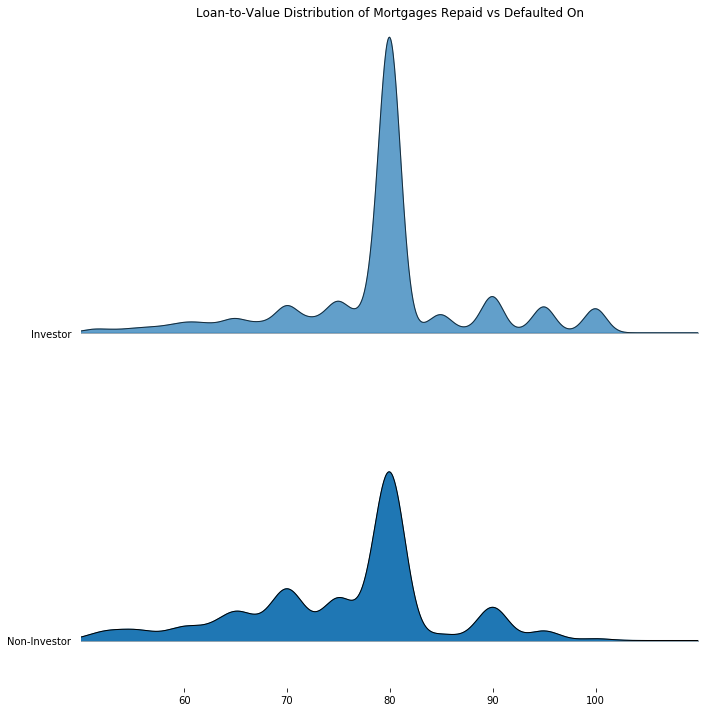

In [60]:
# Create plot to see difference in distribution of loan-to-value for mortgages that defaulted and those that were repaid
%matplotlib inline

fig, axes = joypy.joyplot(df_reg, by="investor_orig_time", column="LTV_orig_time", range_style='own',
                          grid="y", linewidth=1, legend=False, fade=True, figsize=(10,10),
                          labels = ['Investor', 'Non-Investor'],
                          title="Loan-to-Value Distribution of Mortgages Repaid vs Defaulted On",
                          kind="kde", bins=20,
                          x_range=[50,110])

The difference in FICO score distributions is more evident than it was for loan-to-value ratios. In particular, the repaid distribution has significantly more of its distribution in the 700+ FICO score range.

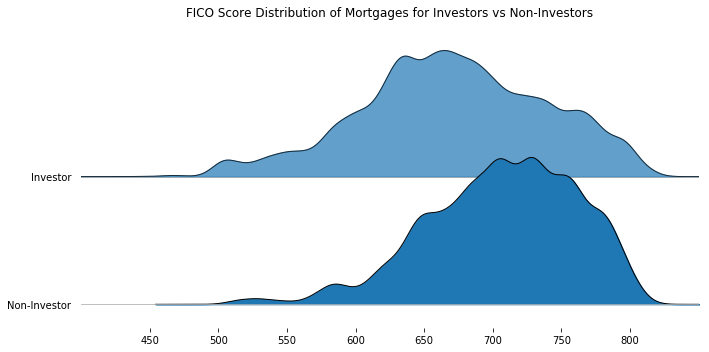

In [61]:
# Create plot to see difference in distribution of FICO Scores for mortgages that defaulted and those that were repaid
%matplotlib inline

fig, axes = joypy.joyplot(df_reg, by="investor_orig_time", column="FICO_orig_time", range_style='own',
                          grid="y", linewidth=1, legend=False, fade=True, figsize=(10,5),
                          labels = ['Investor', 'Non-Investor'],
                          title="FICO Score Distribution of Mortgages for Investors vs Non-Investors",
                          kind="kde", bins=20,
                          x_range=[400, 850])

In [62]:
df_reg.head()

,id,time,orig_time,first_time,mat_time,balance_time,LTV_time,interest_rate_time,hpi_time,gdp_time,...,default_time,payoff_time,status_time,elapsed_perc,perc_bal_paid,Time,Quarter,type,mortgage_type,mortgage_qtr
540,62,33,25,33,140,68552.85,111.602732,11.000,180.52,0.836859,...,0,0,0,0.069565,0.010781,33,2007Q3,3,Single Family,8
541,62,34,25,33,140,68552.85,116.218778,10.400,173.35,-0.314448,...,0,0,0,0.078261,0.010781,34,2007Q4,3,Single Family,9
542,62,35,25,33,140,68552.85,124.292216,10.400,162.09,-2.805844,...,0,0,0,0.086957,0.010781,35,2008Q1,3,Single Family,10
543,62,36,25,33,140,68552.85,132.997922,10.400,151.48,-3.516568,...,0,1,2,0.095652,0.010781,36,2008Q2,3,Single Family,11
544,63,33,25,33,140,155192.77,97.347209,7.205,180.52,0.836859,...,0,0,0,0.069565,0.029281,33,2007Q3,3,Single Family,8


## Statistical Inference

#### Do investors have significantly different FICO scores than non-investors at the time of origination?

Null Hypothesis: Investors and non-investors have the same mean FICO score at origination

Alternative: Investors and non-investors do not have the same mean FICO score

In [63]:
# Filter to the 25th quarter to make independence plausible by removing time series component
df_reg = df.loc[df['orig_time'] == 25, ]

In [64]:
# Create dataframe of id, FICO at origination, and investor/non-investor
df_reg = df_reg.groupby('id')[['FICO_orig_time', 'investor_orig_time', 'LTV_orig_time']].agg({'FICO_orig_time':'max',
                                                                                              'investor_orig_time':'max',
                                                                                             'LTV_orig_time':'max'
                                                                                             }).reset_index()

In [65]:
# Subset into investor and non-investors
inv = df_reg.loc[df_reg['investor_orig_time'] == 1, "FICO_orig_time"]
non = df_reg.loc[df_reg['investor_orig_time'] == 0, "FICO_orig_time"]

In [66]:
print(np.mean(inv))
print(np.mean(non))

700.1517341040462
662.8333333333334


In [67]:
from scipy import stats

# Calculate t-test statistic for samples with different sizes and variances
stats.ttest_ind(inv, non, equal_var = False)

Ttest_indResult(statistic=15.87360225089935, pvalue=2.6054565649434696e-51)

The two sub-populations (investors and non-investors) have statistically different mean FICO scores at time of origination.

### Investor Type & Loan-to-Value Ratios

#### Do investors have significantly different loan-to-value ratios than non-investors at the time of origination?

Null Hypothesis: Investors and non-investors have the same mean loan-to-value ratio at origination

Alternative: Investors and non-investors do not have the same mean loan-to-value ratio

In [68]:
# Subset into investor and non-investors
inv = df_reg.loc[df_reg['investor_orig_time'] == 1, "LTV_orig_time"]
non = df_reg.loc[df_reg['investor_orig_time'] == 0, "LTV_orig_time"]

In [69]:
print(np.mean(inv))
print(np.mean(non))

77.70939306358386
79.98418737060041


In [70]:
# Calculate t-test statistic for samples with different sizes and variances
stats.ttest_ind(inv, non, equal_var = False)

Ttest_indResult(statistic=-6.069836865193294, pvalue=1.8355277150937008e-09)

The two sub-populations (investors and non-investors) have statistically different mean loan-to-value ratios at time of origination.

### Home Type & Loan-to-Value Ratios

#### Do single-family home have significantly different loan-to-value ratios than condos at the time of origination?

Null Hypothesis: Investors and non-investors have the same mean loan-to-value ratio at origination

Alternative: Investors and non-investors do not have the same mean loan-to-value ratio

In [71]:
# Create a single variable corresponding to building type (1 = condo, 2 = urban development, 3 = single family home)
df['type'] = df['REtype_CO_orig_time'] + 2*df['REtype_PU_orig_time'] + 3*df['REtype_SF_orig_time']

In [72]:
# Transform numeric mapping into name of building type
type_lookup = {1:"Condo",
              2:"Urban Development",
              3:"Single Family"}

df['mortgage_type'] = df['type'].map(type_lookup)

In [73]:
# Filter to only quarter 25
def_by_type = df.loc[df['orig_time'] == 25, ]

# Create dataframe to calculate total number of mortgages, defaults, and payoffs by building type
def_by_type = def_by_type.groupby(['id','mortgage_type'])[['FICO_orig_time','LTV_orig_time']].agg({'FICO_orig_time':'max',
                                                                                          'LTV_orig_time':'max'
                                                                                         }).reset_index()

In [74]:
sf_FICO = def_by_type.loc[def_by_type['mortgage_type'] == 'Single Family', 'FICO_orig_time']
co_FICO = def_by_type.loc[def_by_type['mortgage_type'] == 'Condo', 'FICO_orig_time']

In [75]:
print(np.mean(sf_FICO))
print(np.mean(co_FICO))

659.7108477011494
689.7359550561798


In [76]:
# Calculate t-test statistic for samples with different sizes and variances
stats.ttest_ind(sf_FICO, co_FICO, equal_var = False)

Ttest_indResult(statistic=-9.124487964595584, pvalue=1.772516035348622e-18)

In [77]:
sf_LTV = def_by_type.loc[def_by_type['mortgage_type'] == 'Single Family', 'LTV_orig_time']
co_LTV = def_by_type.loc[def_by_type['mortgage_type'] == 'Condo', 'LTV_orig_time']

In [78]:
print(np.mean(sf_LTV))
print(np.mean(co_LTV))

79.75535201149428
79.68623595505619


In [79]:
# Calculate t-test statistic for samples with different sizes and variances
stats.ttest_ind(sf_LTV, co_LTV, equal_var = False)

Ttest_indResult(statistic=0.14343381003709896, pvalue=0.8860084107143291)

## Pairplots for Numeric Variables

In [80]:
df_pairplot = df.loc[:, ['balance_time',
                       'LTV_time',
                       'interest_rate_time',
                       'FICO_orig_time',
                       'default_time']]

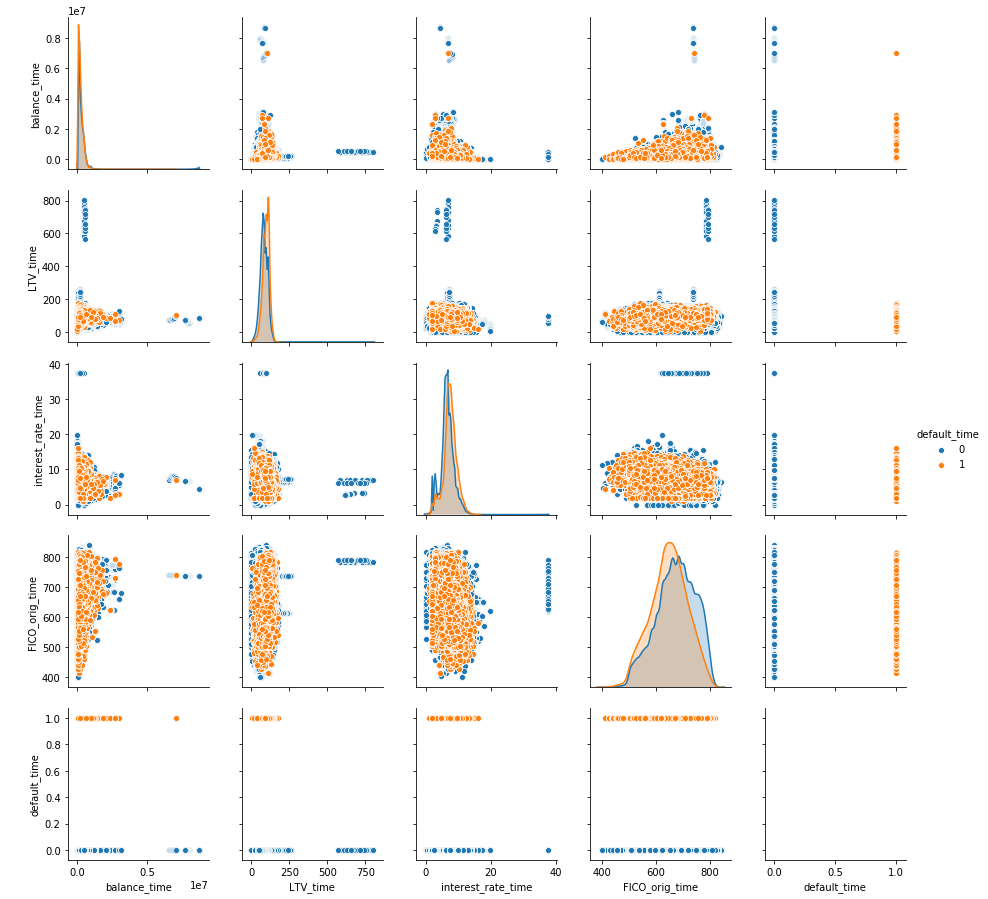

In [81]:
sns.pairplot(df_pairplot, hue = 'default_time')

## Survival Analysis

In [82]:
kp_df = df
kp_df['duration'] = kp_df['time'] - kp_df['orig_time']

In [83]:
# Create data vectors 
durations = kp_df['duration']
event_observed = kp_df['default_time']

Create Kaplan-Meier curve of mortgage "survival" across time, measured by quarters since loan origination.

Text(0.5, 1.0, 'Kaplan Meier Estimate of Mortgage Default')

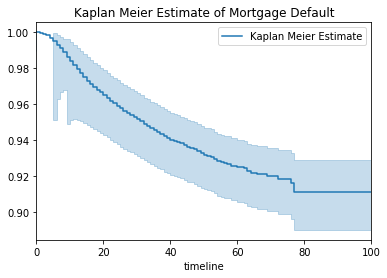

In [84]:
from lifelines import KaplanMeierFitter

# create a kmf object
kmf = KaplanMeierFitter() 

# Fit the data into the model
kmf.fit(durations, event_observed,label='Kaplan Meier Estimate')

# Create an estimate
kmf.plot(ci_show=True)
plt.title('Kaplan Meier Estimate of Mortgage Default')

Split out by home type to compare rates of default by loan maturity between condos, single family homes, and urban developments.

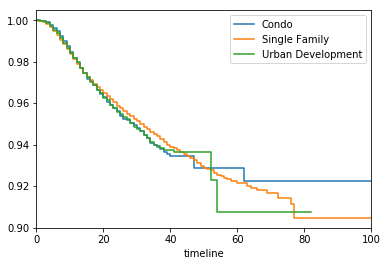

In [85]:
kmf = KaplanMeierFitter()

ax = plt.subplot()

for name, df_ in kp_df[['mortgage_type','default_time', 'duration']].groupby('mortgage_type'):
    kmf.fit(df_['duration'], df_['default_time'], label=name)
    ax = kmf.plot(ax=ax, ci_show=False)

Compare rates of default between investors and non-investors.

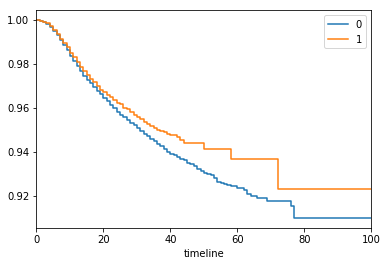

In [86]:
kmf = KaplanMeierFitter()

ax = plt.subplot()

for name, df_ in kp_df[['investor_orig_time','default_time', 'duration']].groupby('investor_orig_time'):
    kmf.fit(df_['duration'], df_['default_time'], label=name)
    ax = kmf.plot(ax=ax, ci_show=False)